# 2 - Mass spectra deduplication with Locality sensitive hashing

In [6]:
# 0) Setup: imports & project root ------------------------------------
import sys
from pathlib import Path

# so that `paths.py` (with PROJECT_ROOT) is on the import path
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from tqdm import tqdm

from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.utils.spectra import PeakListModifiedCosine

# plotting utilities
from benchmark.utils.plots import plot_similarity_kde, plot_dissimilarity_hist_kde

#### Here we load our preprocessed data from previous tutorial 1_data_preparation.ipynb
#### If you do note have hdf5 processed file form previous, or you preprocessed your spectra by yourself and want to skip it, and load your mzML of mgf

In [2]:
# define paths
in_h5 = PROJECT_ROOT / "data" / "rawfiles" / "202312_20_P09-Leaf-r1_1uL_high_quality.hdf5"

# load into memory for fast LSH
msdata = MSData.from_hdf5(in_h5, in_mem=True)
print(f"Loaded {len(msdata)} high-quality spectra with columns: {msdata.columns()}")

Loading dataset 202312_20_P09-Leaf-r1_1uL_high_quality into memory (2000 spectra)...
Loaded 2000 high-quality spectra with columns: ['RT', 'charge', 'file_name', 'precursor_mz', 'scan_number', 'spectrum']


### 2) Compute LSH hashes

We reuse a single LSHProjector for all spectra to guarantee consistent hash space.

In [3]:
# 2a) extract spectra array: shape = (N, 2, n_peaks)
specs = msdata.get_spectra()

# 2b) instantiate & compute hashes
lsh_proj = BatchedPeakListRandomProjection(bin_step=0.5, n_hyperplanes=50)
hashes  = lsh_proj.compute(specs)
print(f"Computed {len(hashes)} hashes; example hash: {hashes[0]}")

Computing LSHs: 100%|██████████| 2000/2000 [00:00<00:00, 2276.41it/s]


Computed 2000 hashes; example hash: b'786a202663fa5e0a28a584694ad780c327417a5905f0950b45a6332e77bf3ebf'


### 3) Find a cluster of size 15–20

We want to show that indeed clustered spectra are similar
Group spectra by identical hash, then pick one group whose size falls in our target range.

In [4]:
# count frequencies of each hash
counts = pd.Series(hashes).value_counts()

target = counts[(counts >= 15) & (counts <= 20)]
assert not target.empty, "No cluster in the desired size range found!"

# pick the first matching hash
cluster_hash = target.index[0]
cluster_size = target.iloc[0]
print(f"Selected hash {cluster_hash} with cluster size = {cluster_size}")

# indices of spectra in this cluster
i_idxs = np.where(hashes == cluster_hash)[0]

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_36456/3377724960.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  counts = pd.Series(hashes).value_counts()


Selected hash b'a857dfeaf75b6dc7684df1f02ae0887d0e0201e6dab5653ed700a882adddbda4' with cluster size = 17


### 4) Visualize intra‑cluster similarity

Compute pairwise modified cosine similarities,to see that spectra within cluster are highly similar then plot:


Pairwise modified‑cosine matrix shape: (17, 17)


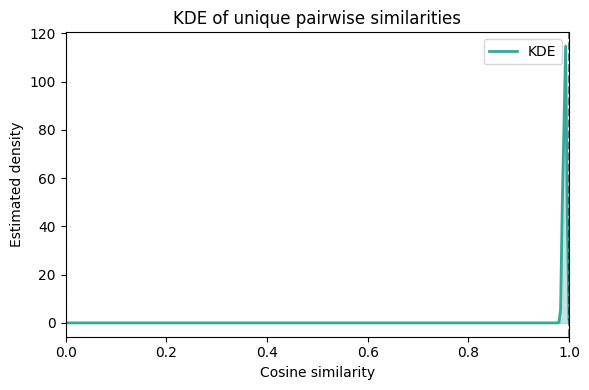

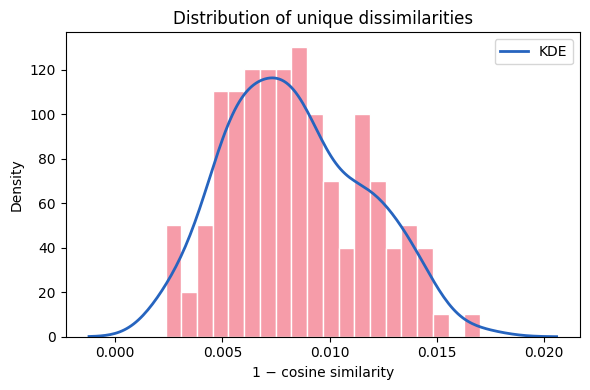

In [7]:
# extract the actual peak lists and precursor m/z for the cluster
cluster_specs = specs[i_idxs]
cluster_prec  = msdata.get_prec_mzs()[i_idxs]

# compute full pairwise similarity matrix
cos_sim = PeakListModifiedCosine()
sim_mat = cos_sim.compute_pairwise(
    specs    = cluster_specs,
    prec_mzs = cluster_prec,
    avg      = False
)
print("Pairwise modified‑cosine matrix shape:", sim_mat.shape)

# 4a) Teal KDE of the similarities
plot_similarity_kde(sim_mat, palette_idx=(1,))

# 4b) Pink histogram + lavender KDE of the affinities
plot_dissimilarity_hist_kde(sim_mat, hist_idx=2, kde_idx=0)

Conclusion:LSH clustering reliably groups highly similar spectra together, as evidenced by the tight intra‑cluster similarity distributions.

Next steps:– Repeat across additional files or whole merged dataset– Tune bin_step & n_hyperplanes– Integrate deduplication into downstream embedding pipelines